# 1. Libraries

In [38]:
import pandas as pd
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import util
import ast
import re
import os
import random
from scipy.stats import variation
from sklearn.metrics.pairwise import cosine_similarity
from heapq import heappush, heappop, heapify


# 2. Helper functions

In [15]:
def cosine_similarity_adapter(x, y):
    """ 
    Calcs the cosine similarity between two vectors
    """
    return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0]

def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def huff(symb2freq):
    huffmansymbols = ""
    huffw = encode(symb2freq)
    for p in huffw:
        huffmansymbols += p[1] * symb2freq[p[0]]
    huff = len(huffmansymbols) / 8
    return huff

def calculate_density(df):
    """
    Calculate the huffman coding bit size of the normalized text of the df
    """
    words = []
    for s in df['normalized_text']:
        for w in ast.literal_eval(s):
            words.append(w)
    
    symb2freq = {}
    for word in words:
        if word in symb2freq:
            symb2freq[word] += 1
        else:
            symb2freq[word] = 1

    return huff(symb2freq)

def dist_and_cv_wv(model):
    """
    Calculates the average sim and coeff of var for 10,000 random pairs of words
        Inputs: 
            - model (word2vec model): a model trained on a president corpus

        Outputs:
            - mean_dist (float): the mean cosine similarity of the 10,000 pairs
            - cv (float): the coefficient of variation of the 10,000 pairs
    """
    distances = []
    word_indexes = len(model.wv.key_to_index.keys()) - 1
    for i in range(10000): 
        rand1 = model.wv.index_to_key[random.randrange(0, word_indexes)]
        rand2 = model.wv.index_to_key[random.randrange(0, word_indexes)]
        dist = model.wv.similarity(rand1, rand2) + 1
        distances.append(dist)
        
    mean_dist = float(sum(distances)) / float(len(distances))
    cv        = variation(distances)

    return mean_dist, cv

def dist_and_cv_dv(model):
    """
    Calculates the average sim and coeff of var for 10,000 random pairs of words
        Inputs: 
            - model (word2vec model): a model trained on a president corpus

        Outputs:
            - mean_dist (float): the mean cosine similarity of the 10,000 pairs
            - cv (float): the coefficient of variation of the 10,000 pairs
    """
    distances = []
    word_indexes = len(model.dv.key_to_index.keys()) - 1
    for i in range(10000): 
        rand1 = model.dv.index_to_key[random.randrange(0, word_indexes)]
        rand2 = model.dv.index_to_key[random.randrange(0, word_indexes)]
        dist = model.dv.similarity(rand1, rand2) + 1
        distances.append(dist)
        
    mean_dist = float(sum(distances)) / float(len(distances))
    cv        = variation(distances)

    return mean_dist, cv

def assign_ideology(president):
    """
    Assigns a president an ideology
    """
    left = ['morales', 'correa', 'sanchez', 'funes', 'maduro', 'chavez']
    center_left = ['kichner', 'bachelet', 'solis', 'colom', 'ortega', 'ollanta', 'lugo', 'tabare', 'mujica']
    center_right = ['chinchilla', 'arias', 'medina', 'fernandez', 'zelaya', 'pena_nieto', 'alan']

    if president in left:
        return 'left'
    elif president in center_left:
        return 'center_left'
    elif president in center_right:
        return 'center_right'
    else:
        return 'right'
    
def assign_populist(president):
    """
    Labels presidents as populist or not
    """
    populist = ['chavez', 'maduro', 'ortega', 'correa', 'morales', 'kirchner', 'uribe']
    if president in populist:
        return 'populist'
    else:
        return 'not_populist'

# 3. Test density of language space

density: the average amount of conceptual information per language unit.

Denser language spaces use less language units (words, sentences, etc.) to conveys meaning.

For spaces with less topics, there should a be higher density?

In [13]:
#set seed and initialize dict
file_path = r"C:\Users\asarr\Documents\Projects\pol-cul-maps-latam\president_csvs"
random.seed(0)
den_dict = {}

for df in os.listdir(file_path):
    #prep
    name = df.split('.')[0]
    pres_df = pd.read_csv(f'{file_path}\{df}')
    
    pres_df['tokenized_sents'] = pres_df['text2'].apply(lambda x: [util.word_tokenize_es(s) for s in util.sent_tokenize_es(x)])
    pres_df['normalized_sents'] = pres_df['tokenized_sents'].apply(lambda x: [util.normalizeTokens_es(s, lemma=False) for s in x])

    pres_df['normalized_sents'] = pres_df['normalized_sents'].apply(lambda x: [s for s in x if len(s) > 0])
    
    #huff value: communication density
    huff_val = calculate_density(pres_df)

    #avg cosine similarity: semantic density
    w2v_model = gensim.models.word2vec.Word2Vec(pres_df['normalized_sents'].sum(), sg=1, window=6)
    avg_cos_sim, cv = dist_and_cv_wv(w2v_model)

    #compile
    den_dict[name] = [huff_val, huff_val/len(pres_df), huff_val/len(pres_df['normalized_text'].sum()), avg_cos_sim, cv]

In [16]:
density = pd.DataFrame(den_dict).T
density.columns = ['huffman', 'huffman_ratio_doc', 'huffman_ratio_text', 'avg_cos_sim_wv', 'cv_wv']
density.head()

,huffman,huffman_ratio_doc,huffman_ratio_text,avg_cos_sim_wv,cv_wv
alan,165290.375,200.351970,0.131578,1.915253,0.053666
arias,31575.000,222.359155,0.131092,1.996782,0.004060
bachelet,164916.500,187.618316,0.124118,1.851611,0.075459
calderon,206975.250,223.757027,0.133629,1.892302,0.061734
cartes,94579.125,207.410362,0.124999,1.905633,0.060526


### Set ideology and populism categories

In [19]:
#set ideology and populism
density['ideology'] = density.index.map(assign_ideology)
density['populist'] = density.index.map(assign_populist)
density.head()

,huffman,huffman_ratio_doc,huffman_ratio_text,avg_cos_sim_wv,cv_wv,ideology,populist
alan,165290.375,200.351970,0.131578,1.915253,0.053666,center_right,not_populist
arias,31575.000,222.359155,0.131092,1.996782,0.004060,center_right,not_populist
bachelet,164916.500,187.618316,0.124118,1.851611,0.075459,center_left,not_populist
calderon,206975.250,223.757027,0.133629,1.892302,0.061734,right,not_populist
cartes,94579.125,207.410362,0.124999,1.905633,0.060526,right,not_populist


## Huffman ratios
Measure communication density

<Axes: title={'center': 'Huffman Ratio by President, per doc'}>

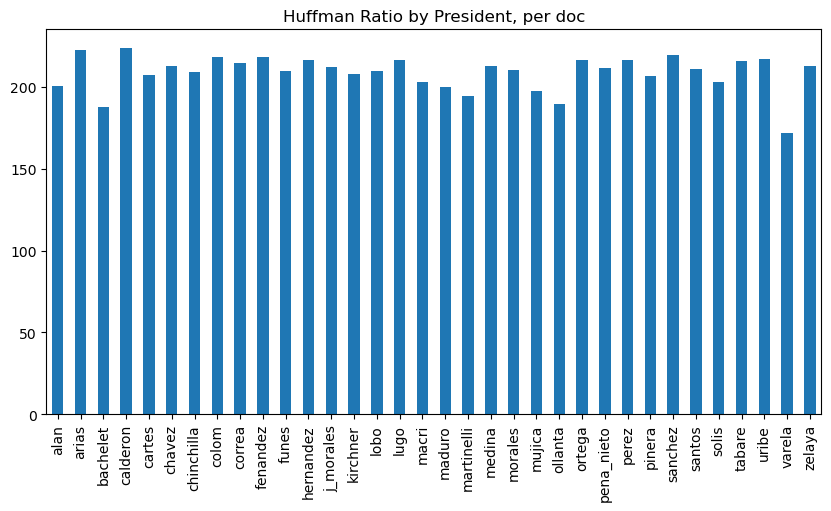

In [9]:
#graph huffman _ratio
density['huffman_ratio_doc'].plot(kind='bar', figsize=(10, 5), title='Huffman Ratio by President, per doc')

<Axes: title={'center': 'Huffman Ratio by President, full text'}>

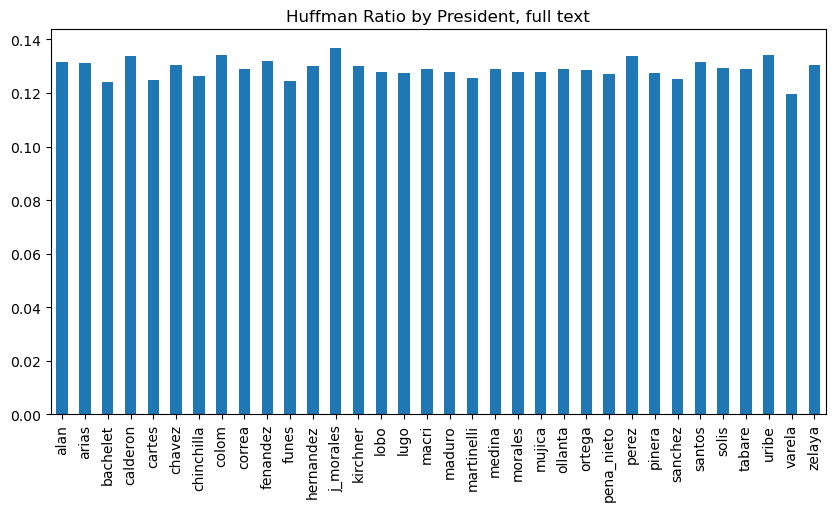

In [10]:
density['huffman_ratio_text'].plot(kind='bar', figsize=(10, 5), title='Huffman Ratio by President, full text')

## Average cosine similarity
measures semantic density

<Axes: title={'center': 'Average Cosine Similarity by President'}>

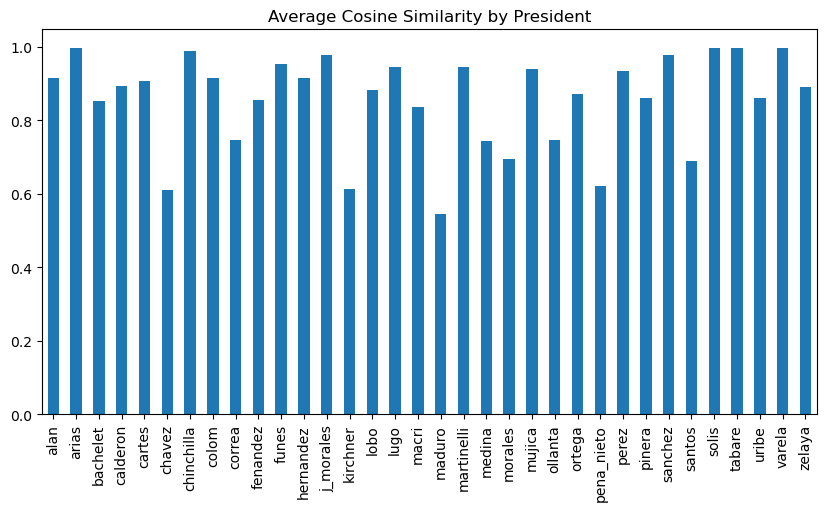

In [22]:
# graph avg_cos_sim
density['avg_cos_sim_wv'] = density['avg_cos_sim_wv'].apply(lambda x: x - 1)
density['avg_cos_sim_wv'].plot(kind='bar', figsize=(10, 5), title='Average Cosine Similarity by President')

<Axes: title={'center': 'Coefficient of Variation by President'}>

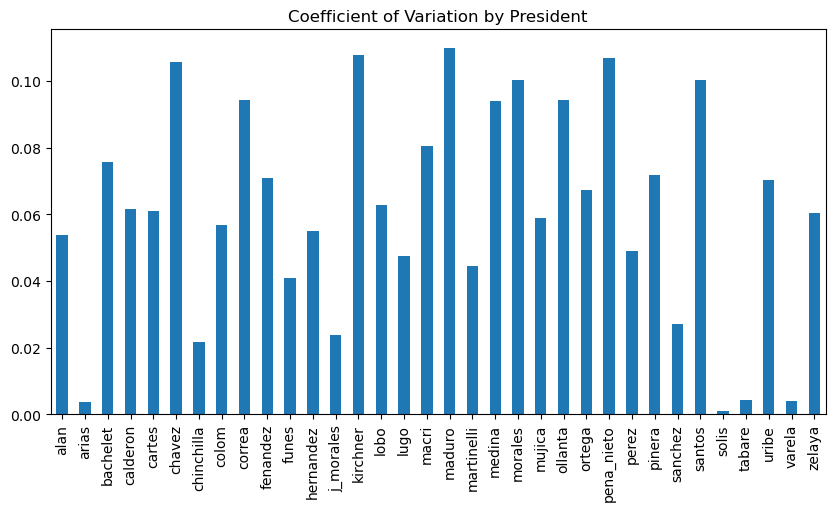

In [13]:
density['cv'].plot(kind='bar', figsize=(10, 5), title='Coefficient of Variation by President')

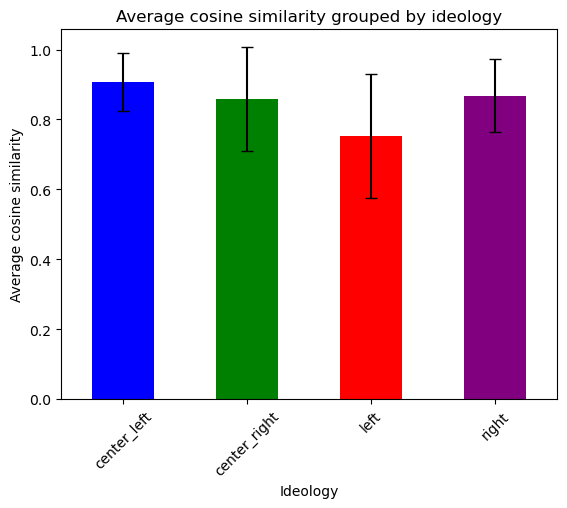

In [33]:
import matplotlib.pyplot as plt

grouped = density.groupby('ideology')['avg_cos_sim_wv'].agg(['mean', 'std'])

fig, ax = plt.subplots()
grouped['mean'].plot(kind='bar', yerr=grouped['std'], ax=ax, capsize=4, color=['blue', 'green', 'red', 'purple'])
ax.set_title('Average cosine similarity grouped by ideology')
ax.set_xlabel('Ideology')
ax.set_ylabel('Average cosine similarity')
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped.index, rotation=45)
plt.show()

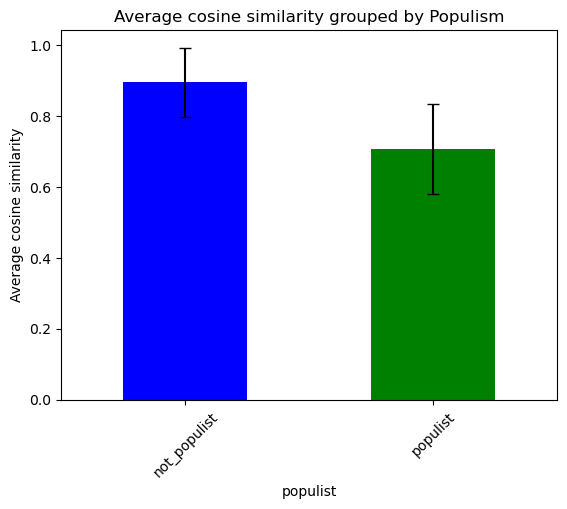

In [34]:
grouped = density.groupby('populist')['avg_cos_sim_wv'].agg(['mean', 'std'])

fig, ax = plt.subplots()
grouped['mean'].plot(kind='bar', yerr=grouped['std'], ax=ax, capsize=4, color=['blue', 'green', 'red'])  # Customize colors as needed
ax.set_title('Average cosine similarity grouped by Populism')
ax.set_ylabel('Average cosine similarity')
ax.set_xticks(range(len(grouped)))
ax.set_xticklabels(grouped.index, rotation=45)
plt.show()


# 5. Doc2Vec

How similar are documents inside a presidents subcorpus?

In [39]:
doc_den_dict = {}

for df in os.listdir(file_path):
    #prep
    name = df.split('.')[0]
    pres_df = pd.read_csv(f'{file_path}\{df}')

    pres_df['normalized_text'] = pres_df['normalized_text'].apply(lambda x: ast.literal_eval(x))

    #create list of lists of tagged word
    tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(pres_df['normalized_text'])]

    #train model
    model = Doc2Vec(vector_size=100, window=6, min_count=2, epochs = 40)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    #avg cosine similarity: semantic density
    avg_cos_sim, cv = dist_and_cv_dv(model)

    #compile
    doc_den_dict[name] = [avg_cos_sim, cv]


In [40]:
doc_density = pd.DataFrame(doc_den_dict).T
doc_density.columns = ['avg_cos_sim', 'cv']
density = density.join(doc_density)
density.head()

,huffman,huffman_ratio_doc,huffman_ratio_text,avg_cos_sim_wv,cv_wv,ideology,populist,avg_cos_sim,cv
alan,165290.375,200.351970,0.131578,0.915253,0.053666,center_right,not_populist,1.279762,0.145934
arias,31575.000,222.359155,0.131092,0.996782,0.004060,center_right,not_populist,1.783445,0.087902
bachelet,164916.500,187.618316,0.124118,0.851611,0.075459,center_left,not_populist,1.265366,0.136159
calderon,206975.250,223.757027,0.133629,0.892302,0.061734,right,not_populist,1.256573,0.145765
cartes,94579.125,207.410362,0.124999,0.905633,0.060526,right,not_populist,1.301776,0.152860


<Axes: title={'center': 'Average Cosine Similarity by President'}>

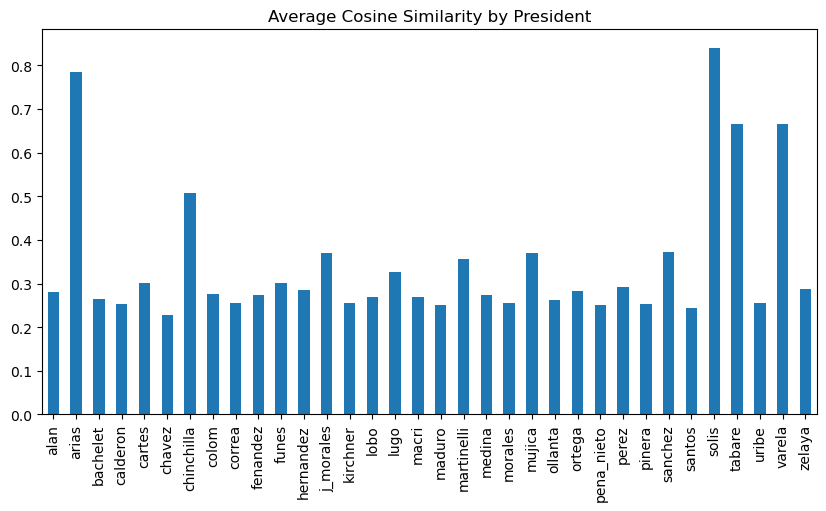

In [55]:
#graph avg_cos_sim
doc_density['avg_cos_sim'] = doc_density['avg_cos_sim'].apply(lambda x: x - 1)
doc_density['avg_cos_sim'].plot(kind='bar', figsize=(10, 5), title='Average Cosine Similarity by President')

<Axes: title={'center': 'Coefficient of Variation by President'}>

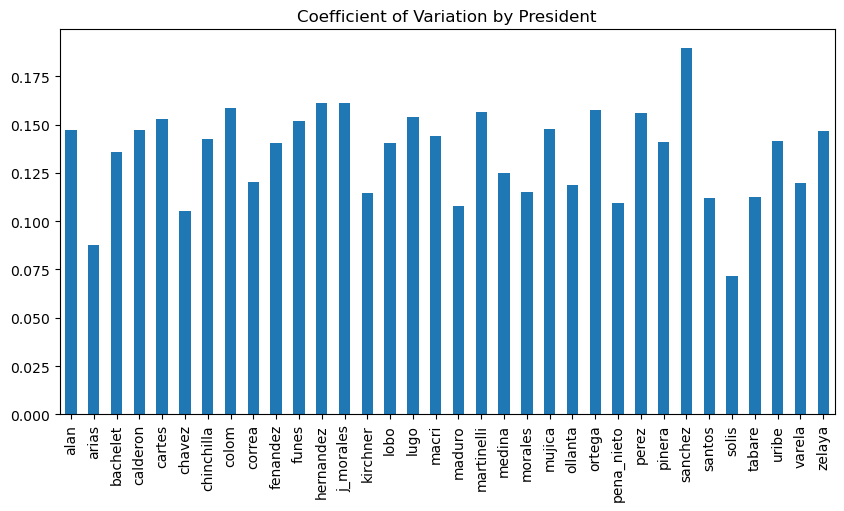

: 

In [56]:
#graph cv
doc_density['cv'].plot(kind='bar', figsize=(10, 5), title='Coefficient of Variation by President')

## 6. Top2Vec